In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage
import seaborn as sns

## 필요 함수 정의

1. 데이터 분포 시각화

In [2]:
def plot_distribution(dataframe_name, columns_to_plot):
    num_columns = len(columns_to_plot)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    fig.suptitle("Distribution of Molecular Properties", fontsize=16)

    for i, column in enumerate(columns_to_plot):
        row_idx = i // 3
        col_idx = i % 3
        axes[row_idx, col_idx].hist(dataframe_name[column], bins=30, edgecolor='black')
        axes[row_idx, col_idx].set_xlabel(column)
        axes[row_idx, col_idx].set_ylabel("Frequency")

    # Adjust layout and spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    plt.show()

2. 데이터셋에 존재하는 atom별 개수 시각화

In [3]:
def plot_atom_counts(dataframe_name):
    atom_counts = {'C': 0, 'H': 0, 'N': 0, 'O': 0, 'P': 0, 'S': 0, 'F': 0, 'Cl': 0}

    for smiles in dataframe_name['Can_SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            elements = mol.GetAtoms()
            for element in elements:
                symbol = element.GetSymbol()
                if symbol in atom_counts:
                    atom_counts[symbol] += 1

    # Create a DataFrame to store the atom counts
    atom_counts_df = pd.DataFrame.from_dict(atom_counts, orient='index', columns=['Count'])

    # Reset the index to include the atom symbols as a column
    atom_counts_df.reset_index(inplace=True)
    atom_counts_df.rename(columns={'index': 'Atom'}, inplace=True)

    # Exclude 'C' and 'H' atoms from the count plot
    atom_counts_plot = atom_counts_df[~atom_counts_df['Atom'].isin(['C', 'H'])]

    # Plot the count plot
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Atom', y='Count', data=atom_counts_plot, palette='pastel')
    plt.xlabel('Atom')
    plt.ylabel('Count')
    plt.title('Atom Counts in the Molecules Dataset (Excluding C and H)')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(int(height)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(ax.patches)

    plt.show()

3. Canonicalize 함수

In [4]:
def canonical_smiles(isomeric_smiles):
    mol = Chem.MolFromSmiles(isomeric_smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        return None

4. Data curation 함수

In [5]:
def curation(smiles):
    # Check for delocalized charged groups or stereochemistry in the SMILES
    delocal_charged = int('-' in smiles or '+' in smiles or '@' in smiles)

    # Convert SMILES to RDKit Mol object
    mol = Chem.MolFromSmiles(smiles)

    # Check for nitrogen with protons
    protic_N = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'N' and atom.GetNumImplicitHs() > 0:
            protic_N = 1
            break

    # Check for alcohol
    alcohol = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'O' and atom.GetNumImplicitHs() > 0:
            alcohol = 1
            break

    # Check for thiol
    thiol = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'S' and atom.GetNumImplicitHs() > 0:
            thiol = 1
            break

    # Check for PH
    PH = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'P' and atom.GetNumImplicitHs() > 0:
            PH = 1
            break

    # Check for three or four-membered rings
    ring_sizes = set(len(ring) for ring in Chem.GetSSSR(mol))
    small_ring = int(3 in ring_sizes or 4 in ring_sizes)

    # Return the results as a tuple with six elements
    return delocal_charged, protic_N, alcohol, thiol, PH, small_ring


## 모든 csv 파일 하나의 DataFrame으로 concat

In [6]:
directory_path = './' ######## 추출한 csv 파일들이 있는 경로

csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

dataframes_list = []
for csv_file in csv_files:
    csv_file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(csv_file_path)
    dataframes_list.append(df)

merged_df = pd.concat(dataframes_list, ignore_index=True)


In [7]:
merged_df.head(3)

,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES
0,25002,C14H28O,212.37152,43,15,1.514198,-5.796025,1.028590,6.824615,CC(C)CC(C)CCCC(C)COC=C
1,25003,C4H6Cl2O,140.99584,13,7,1.474742,-7.621909,-1.542886,6.079023,CC(CCl)(C=O)Cl
2,25004,C15H32O,228.41398,48,16,1.409543,-6.827337,1.877586,8.704922,CC(C)CC(CC(C)C)CC(CC(C)C)O


## Canonicalize

In [8]:
merged_df['Can_SMILES'] = merged_df['Isomeric_SMILES'].apply(canonical_smiles)

[05:06:15] WARNING: not removing hydrogen atom without neighbors


In [9]:
merged_df.columns

Index(['i', 'molecular_formula', 'molecular_weight', 'atom_count',
       'heavy_atom_count', 'total_dipole_moment', 'homo', 'lumo', 'gap',
       'Isomeric_SMILES', 'Can_SMILES'],
      dtype='object')

## Data 분포 확인

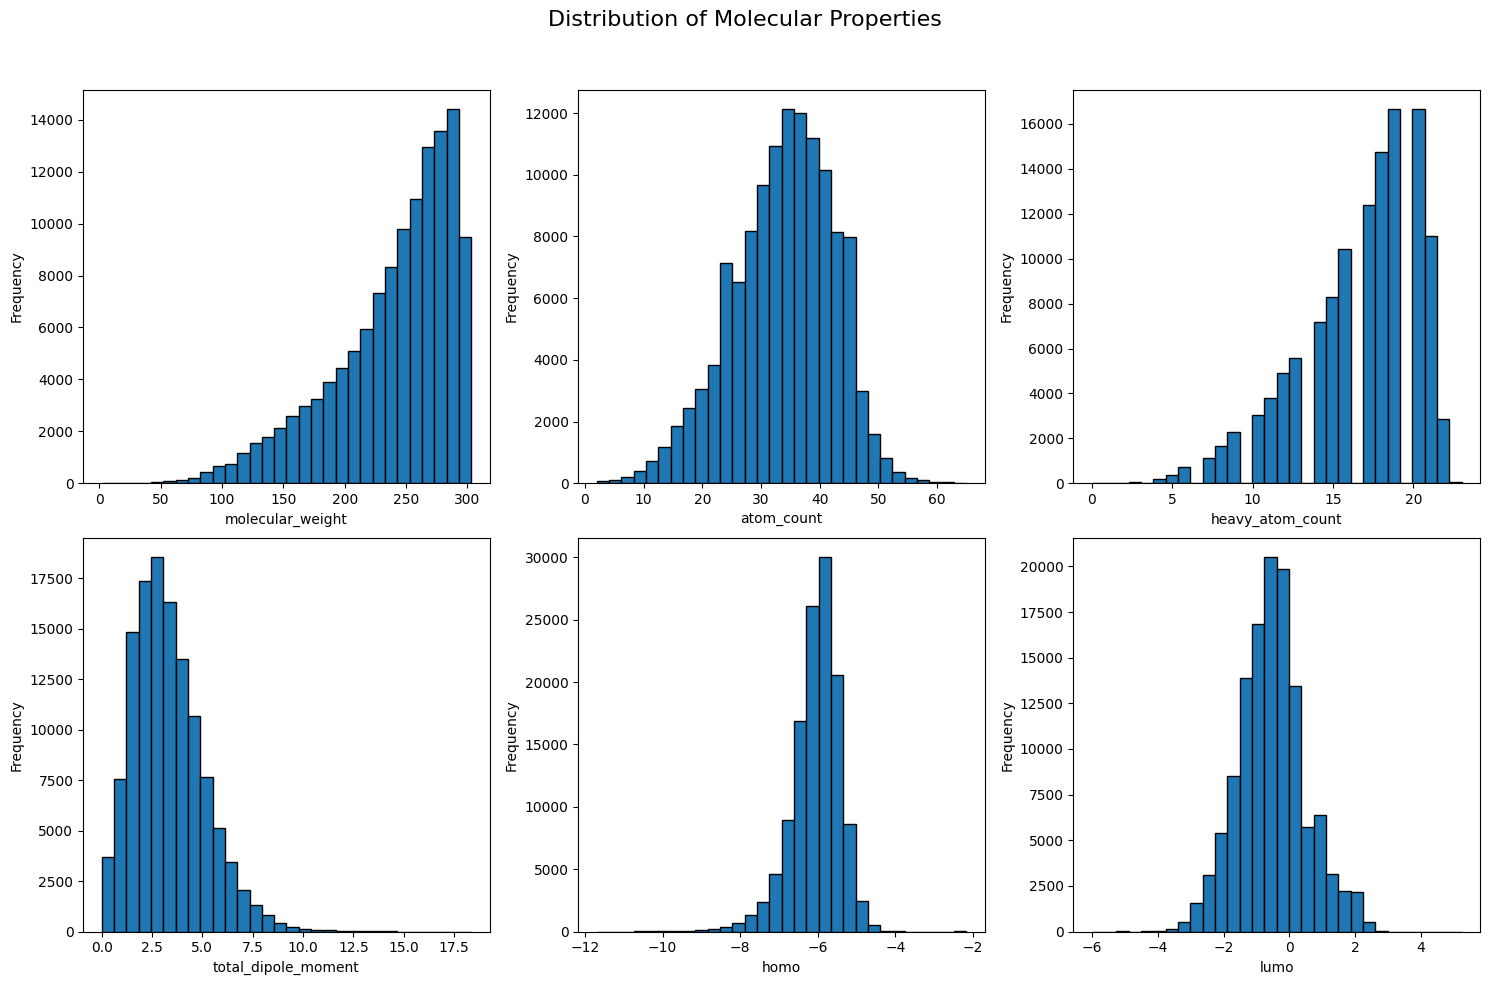

In [10]:
plot_distribution(merged_df, ["molecular_weight", "atom_count", "heavy_atom_count", "total_dipole_moment", "homo", "lumo"])

__데이터셋에 EC 있는지 찾아봤으나, 없음. 찾아야 함__ ### 혹시 발견되면 알려주세요 T^T

In [11]:
merged_df[merged_df['Can_SMILES']=='C1COC(=O)O1']

,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES


[05:06:30] WARNING: not removing hydrogen atom without neighbors


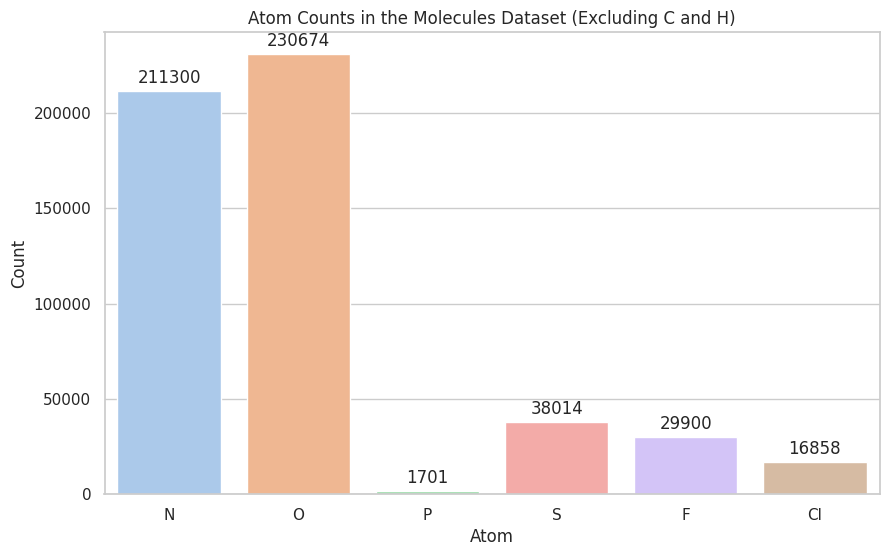

In [12]:
plot_atom_counts(merged_df)

## Curation

__1. delocalized electron의 이동에 의해 charge separation된 분자 제외(nucleophilicity)__<br>
__2. stereochemistry 표현된 분자 제외__<br>
__3. protic 물질 제외__<br>
- primary, secondary amine<br>
- alcohol<br>
- thiol<br>
- P : # 결합 수 3, 5 가 아니면 H가 붙으므로 제외<br>

__4. 불안정한 물질 제외__<br>
- 3-membered ring<br>
- 4-membered ring<br>

__5. bridged molecule 제거__<br>

In [13]:
merged_df[['delocal_charged', 'protic_N', 'alcohol', 'thiol', 'PH', 'small_ring']] = merged_df['Can_SMILES'].apply(curation).tolist()

[05:06:46] WARNING: not removing hydrogen atom without neighbors


In [14]:
print('delocal_charged: ', merged_df['delocal_charged'].sum())
print('protic_N: ', merged_df['protic_N'].sum())
print('alcohol: ', merged_df['alcohol'].sum())
print('thiol: ', merged_df['thiol'].sum())
print('PH: ', merged_df['PH'].sum())
print('small_ring: ', merged_df['small_ring'].sum())

delocal_charged:  26689
protic_N:  61037
alcohol:  41003
thiol:  11841
PH:  182
small_ring:  10500


## Curation된 분자 추출 및 분포 시각화

In [15]:
new_df = merged_df[(merged_df['protic_N'] == 0) & (merged_df['delocal_charged'] == 0) & (merged_df['alcohol'] == 0) & (merged_df['thiol'] == 0) & (merged_df['PH'] == 0) & (merged_df['small_ring'] == 0)].copy()

In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22348 entries, 0 to 123990
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   i                    22348 non-null  int64  
 1   molecular_formula    22348 non-null  object 
 2   molecular_weight     22348 non-null  float64
 3   atom_count           22348 non-null  int64  
 4   heavy_atom_count     22348 non-null  int64  
 5   total_dipole_moment  22348 non-null  float64
 6   homo                 22348 non-null  float64
 7   lumo                 22348 non-null  float64
 8   gap                  22348 non-null  float64
 9   Isomeric_SMILES      22348 non-null  object 
 10  Can_SMILES           22348 non-null  object 
 11  delocal_charged      22348 non-null  int64  
 12  protic_N             22348 non-null  int64  
 13  alcohol              22348 non-null  int64  
 14  thiol                22348 non-null  int64  
 15  PH                   22348 non-null  int

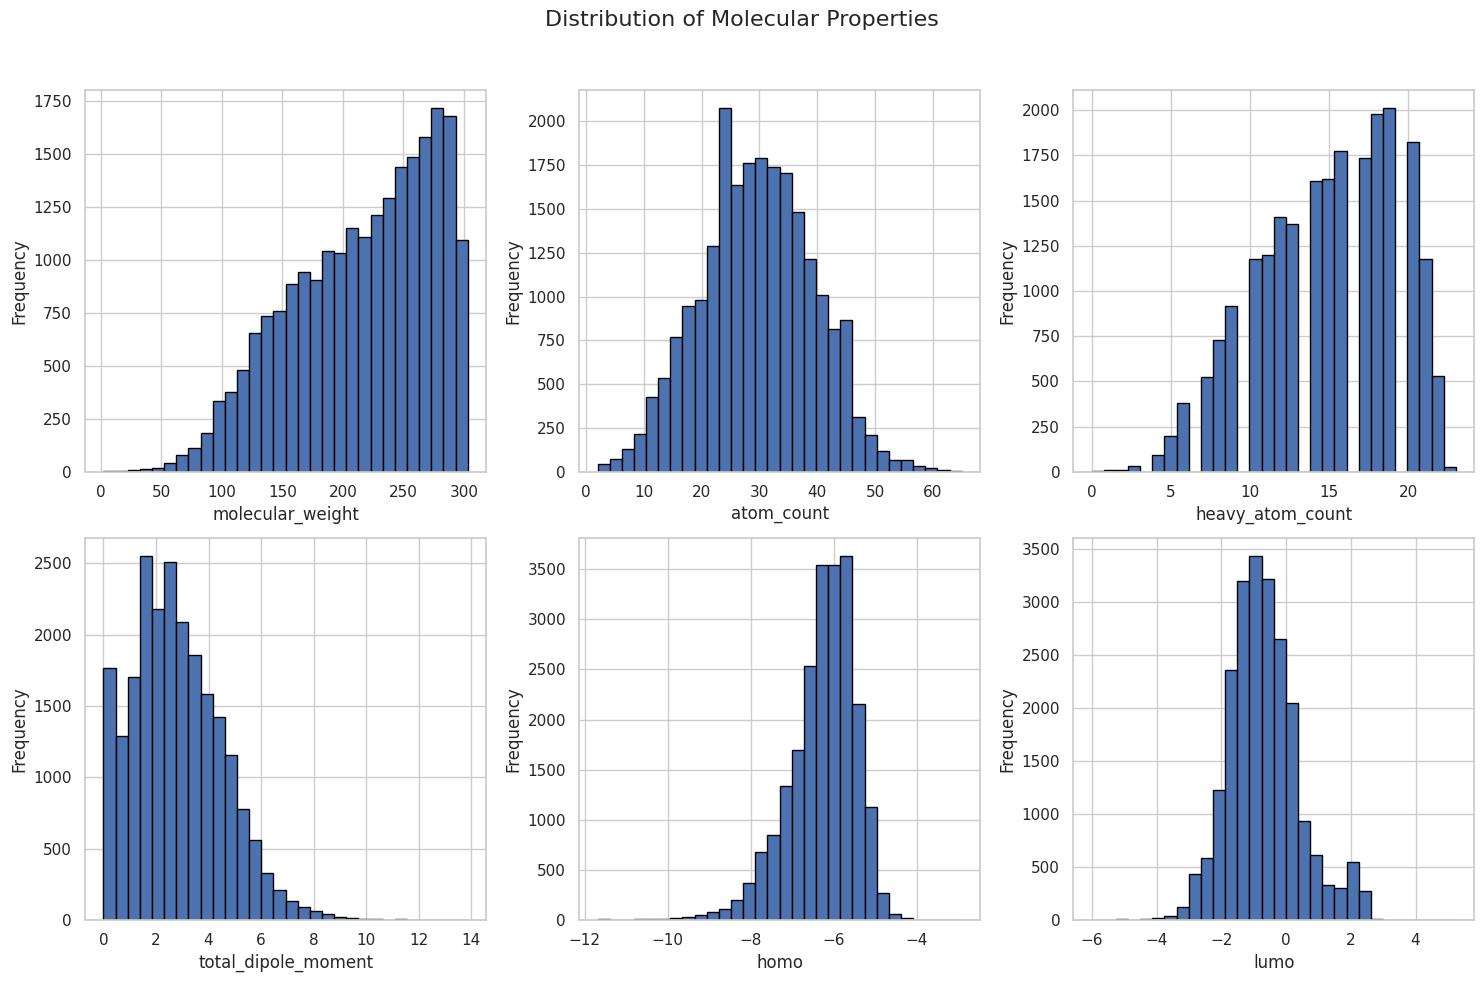

In [17]:
plot_distribution(new_df, ["molecular_weight", "atom_count", "heavy_atom_count", "total_dipole_moment", "homo", "lumo"])

[05:08:07] WARNING: not removing hydrogen atom without neighbors


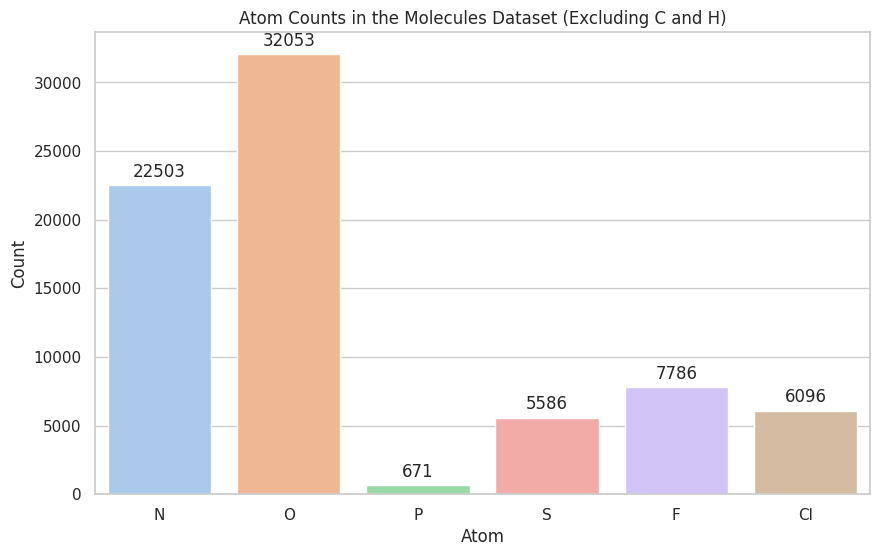

In [18]:
plot_atom_counts(new_df)

### CSV로 저장

In [20]:
new_df.to_csv('./PubChemQC_22348.csv')  #######파일명 수정 "PubChemQC__(new_df의 데이터 개수)"

* 데이터 더 긁어야 함. 최소 Curation 이후 데이터 10만개 목표
* EC 가 있는 데이터 찾아야 함.
* Bridged data 제거하는 함수 정의해야 함.